# Title

In [1]:
import re, os, sys, pickle, pickle, math
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

numpy.random.seed(7)

Plotting setup:

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

# import random
# df = DataFrame({'x': random.sample(range(1, 100), 5), 
#                 'y': random.sample(range(1, 100), 5),
#                 'z': [1,0,0,1,0],
#                 'k': ['male','male','male','female','female'] })

# with sns.color_palette("Set1"):
#     with sns.axes_style('dark'): # whitegrid, ticks
#         with sns.plotting_context('paper', font_scale=1): # paper, notebook, talk”, poster
#             g = sns.lmplot('x', 'y', data=df, hue='z', col='k', fit_reg=False, size=3)

# mpld3.display(ax.fig) # if you want d3

Ignore deprecation warnings from mainly seaborn:

Local code in the scripts dir on the cluster:

Import variables global to the entire analysis:

### Analysis dirs

## Convenience functions

## Load meta data

In [3]:
pandas.read_csv('ihs_non_africans_low_diversity.csv', sep=';').head()

FileNotFoundError: File b'ihs_non_africans_low_diversity.csv' does not exist

In [ ]:
ihh_data = pandas.read_csv('ihs_non_africans_low_diversity.csv', sep=';', header=0, 
                     names=['id', 'chrom', 'pos', 'ihs', 'logp', 'is_sweep'])
ihh_data.head()

In [4]:
plt.hist(ihh_data.ihs.loc[~numpy.isnan(ihh_data.ihs)]) ;

NameError: name 'ihh_data' is not defined

In [17]:
ihh_data_new = pandas.read_csv('ihs_non_africans_low_diversity_new.csv', header=0, 
                     names=['id', 'chrom', 'pos', 'ihs', 'logp', 'is_sweep'])
ihh_data_new.head()

,id,chrom,pos,ihs,logp,is_sweep
0,X:X_1248788,1,1248788,-6.051511,8.843167,NaN
1,X:X_1263463,1,1263463,0.990990,0.492562,NaN
2,X:X_1314481,1,1314481,-4.108881,4.400575,NaN
3,X:X_2162893,1,2162893,0.091087,0.032722,NaN
4,X:X_2667033,1,2667033,1.037796,0.523799,NaN


In [19]:
#ihh_data.merge(ehh_data, on=['id', 'chrom', 'pos']).head()

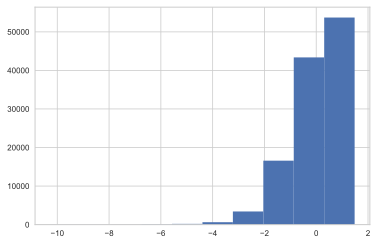

In [20]:
plt.hist(ihh_data_new.ihs.loc[~numpy.isnan(ihh_data_new.ihs)]) ;

In [21]:

ehh_data = pandas.read_csv('ehh_for_all_snps_X.csv', header=0, 
                     names=['id', 'chrom', 'pos', 'freq_a', 'ihh_a', 'ihh_d', 'ies_tang', 'ies_sab'])
ehh_data.head()

,id,chrom,pos,freq_a,ihh_a,ihh_d,ies_tang,ies_sab
0,X:X_366191,1,366191.0,0.0,0.0,NaN,NaN,NaN
1,X:X_399571,1,399571.0,0.0,0.0,NaN,NaN,NaN
2,X:X_399575,1,399575.0,1.0,NaN,0.0,NaN,NaN
3,X:X_399586,1,399586.0,1.0,NaN,0.0,NaN,NaN
4,X:X_451262,1,451262.0,0.0,0.0,NaN,NaN,NaN


In [22]:
ampliconic_regions = pandas.read_hdf('ampliconic_regions.hdf')
ampliconic_regions.head()

,chrom,start,end
0,X,48202745,48292983
1,X,48976199,49062381
2,X,49076004,49444844
3,X,51395467,51492862
4,X,51775560,51966529


In [23]:
extended_peak_regions = pandas.read_hdf('extended_peak_regions.hdf')
extended_peak_regions.head()

,pos,peak_start,peak_end,start_pos,end_pos,prop_swept,swept_indivs
0,11300000.0,11200000,11400000,11100000,11500000,0.328571,"['B_Australian-4', 'S_Adygei-1', 'S_Aleut-1', ..."
1,14750000.0,14700000,14800000,14600000,14900000,0.357143,"['B_Papuan-15', 'S_Abkhasian-1', 'S_Adygei-1',..."
2,19850000.0,19800000,19900000,19700000,20000000,0.807143,"['B_Australian-4', 'B_Crete-2', 'B_Dai-4', 'B_..."
3,21250000.0,21200000,21300000,21100000,21400000,0.800000,"['B_Australian-4', 'B_Crete-2', 'B_French-3', ..."
4,27950000.0,27900000,28000000,27900000,28100000,0.164286,"['B_Dai-4', 'B_Karitiana-3', 'S_Adygei-1', 'S_..."


In [24]:
sweep_data = pandas.read_hdf('sweep_data.hdf')
missing_regions = pandas.read_hdf('missing_regions.hdf')

In [25]:
total_swept = (sweep_data
           .assign(is_non_african = lambda df: df.region_1 != 'Africa')
           .groupby(['start', 'end', 'is_non_african'])['swept']
#           .groupby(['start', 'end'])['swept']
           .aggregate(['sum', 'size'])
           .rename(columns={'sum': 'nr_swept', 'size': 'total'})
           .reset_index()
           .assign(pos = lambda df: df.start + (df.end - df.start) / 2,
                   prop_swept = lambda df: df.nr_swept / df.total)
          )
total_swept.head() 

,start,end,is_non_african,nr_swept,total,pos,prop_swept
0,0,100000,False,0.0,22,50000.0,0.0
1,0,100000,True,0.0,140,50000.0,0.0
2,100000,200000,False,0.0,22,150000.0,0.0
3,100000,200000,True,0.0,140,150000.0,0.0
4,200000,300000,False,0.0,22,250000.0,0.0


In [26]:
non_afr_total_swept = total_swept.loc[total_swept.is_non_african].reset_index()
afr_total_swept = total_swept.loc[~total_swept.is_non_african].reset_index()
non_afr_total_swept.head()

,index,start,end,is_non_african,nr_swept,total,pos,prop_swept
0,1,0,100000,True,0.0,140,50000.0,0.0
1,3,100000,200000,True,0.0,140,150000.0,0.0
2,5,200000,300000,True,0.0,140,250000.0,0.0
3,7,300000,400000,True,0.0,140,350000.0,0.0
4,9,400000,500000,True,0.0,140,450000.0,0.0


In [27]:
human_chimp_low_ils_regions_chrX = pandas.read_hdf('human_chimp_low_ils_regions_chrX.hdf')


In [28]:
peak_data = pandas.read_table('maria.tsv')
peak_data.head()

,Unnamed: 0,pos,peak_start,peak_end,start_pos,end_pos,prop_swept,swept_indivs
0,0,11300000.0,11200000,11400000,11100000,11500000,0.323944,"['B_Australian-4', 'S_Adygei-1', 'S_Aleut-1', ..."
1,1,14750000.0,14700000,14800000,14500000,14900000,0.338028,"['B_Papuan-15', 'S_Abkhasian-1', 'S_Adygei-1',..."
2,2,17900000.0,17700000,18100000,17600000,18100000,0.169014,"['B_French-3', 'S_Aleut-1', 'S_Basque-1', 'S_B..."
3,3,19850000.0,19800000,19900000,19700000,20000000,0.809859,"['B_Australian-4', 'B_Crete-2', 'B_Dai-4', 'B_..."
4,4,21250000.0,21200000,21300000,21100000,21400000,0.809859,"['B_Australian-4', 'B_Crete-2', 'B_French-3', ..."


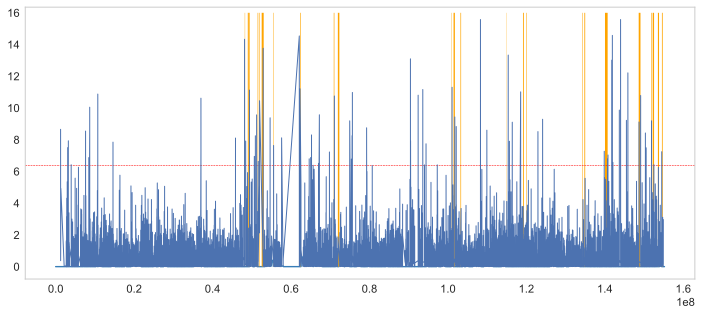

In [29]:
with sns.plotting_context('paper', font_scale=1.4):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(12, 5))

        x = [j for i in zip(non_afr_total_swept.start, non_afr_total_swept.end) for j in i]
        y = [j for i in zip(non_afr_total_swept.prop_swept, non_afr_total_swept.prop_swept) for j in i]      
        g = ax.plot(x, y, color=set1['blue'], zorder=1)        
        ax.fill_between(x, 0, y, color=set1['blue'], alpha=0.4, zorder=1)
        
        
#        fig, ax = plt.subplots(1, 1, figsize=(50, 8))
        plt.plot(ihh_data.pos, ihh_data.logp, linewidth=1, zorder=3)


#         for tup in extended_peak_regions.itertuples():
#             g = ax.add_patch(Rectangle((tup.start_pos, 0), tup.end_pos-tup.start_pos, 16, 
#                              facecolor='lightgrey', 
#                              linewidth=0,
#                              #edgecolor=None,#region_colors[reg], 
#                              zorder=1))

        for tup in ampliconic_regions.itertuples():
            g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 16, 
                             facecolor='orange', 
                             linewidth=0,
                             zorder=2))

        cut = -math.log10(0.05 / len(ihh_data))
        ax.axhline(y=cut, color='red', linewidth=0.5, linestyle='dashed')

        #mpld3.display(fig)

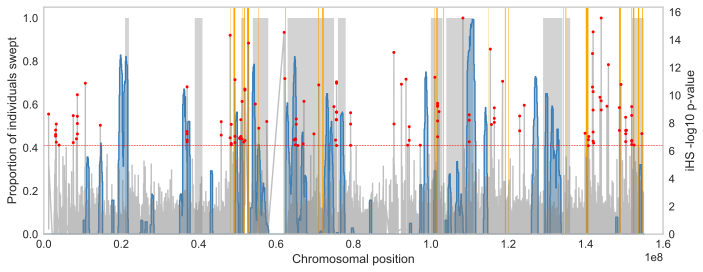

In [37]:
#with sns.color_palette([set1['blue'], set1['red']]):
with sns.plotting_context('paper', font_scale=1.4):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10, 4))

        for tup in human_chimp_low_ils_regions_chrX.itertuples():
            g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                             facecolor='lightgrey', 
                             linewidth=0,
                             zorder=0))

        x = [j for i in zip(non_afr_total_swept.start, non_afr_total_swept.end) for j in i]
        y = [j for i in zip(non_afr_total_swept.prop_swept, non_afr_total_swept.prop_swept) for j in i]      
        g = ax.plot(x, y, color=set1['blue'], zorder=1)        
        ax.fill_between(x, 0, y, color=set1['blue'], alpha=0.4, zorder=1)

        for tup in ampliconic_regions.itertuples():
            g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 16, 
                             facecolor='orange', 
                             linewidth=0.1,
                             zorder=2))
        
        extra_ax = ax.twinx()
        extra_ax.plot(ihh_data.pos, ihh_data.logp, c='grey', alpha=0.5, zorder=0)
#         extra_ax.fill_between(ihh_data.pos, ihh_data.logp, color='grey', alpha=0.4, zorder=0)
        extra_ax.grid(False)        
        extra_ax.set_ylim(0,)

        cut = -math.log10(0.05 / len(ihh_data))
        extra_ax.axhline(y=cut, color='red', linewidth=0.5, linestyle='dashed')

        extra_ax.plot(ihh_data.loc[ihh_data.logp > cut].pos, ihh_data.loc[ihh_data.logp > cut].logp, 
                      'ro', markersize=3)

        ax.set_ylim(0,)
        ax.set_xlim(0,160e6)
        
                    
        ax.set_ylabel('Proportion of individuals swept')
        ax.set_xlabel('Chromosomal position')
        extra_ax.set_ylabel('iHS -log10 p-value')
        plt.tight_layout()
                
        plt.savefig('maria_ihh.pdf')
  

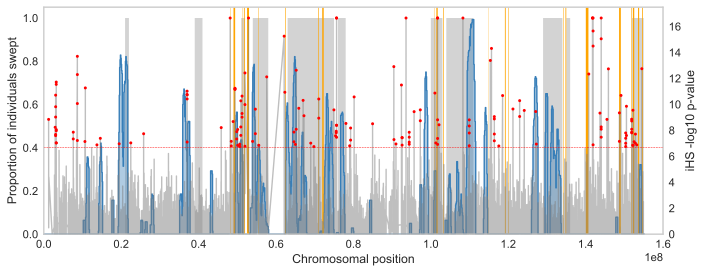

In [39]:
#with sns.color_palette([set1['blue'], set1['red']]):
with sns.plotting_context('paper', font_scale=1.4):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10, 4))

        for tup in human_chimp_low_ils_regions_chrX.itertuples():
            g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                             facecolor='lightgrey', 
                             linewidth=0,
                             zorder=0))

        x = [j for i in zip(non_afr_total_swept.start, non_afr_total_swept.end) for j in i]
        y = [j for i in zip(non_afr_total_swept.prop_swept, non_afr_total_swept.prop_swept) for j in i]      
        g = ax.plot(x, y, color=set1['blue'], zorder=1)        
        ax.fill_between(x, 0, y, color=set1['blue'], alpha=0.4, zorder=1)

        for tup in ampliconic_regions.itertuples():
            g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 16, 
                             facecolor='orange', 
                             linewidth=0.1,
                             zorder=2))
        
        extra_ax = ax.twinx()
        extra_ax.plot(ihh_data_new.pos, ihh_data_new.logp, c='grey', alpha=0.5, zorder=0)
#         extra_ax.fill_between(ihh_data.pos, ihh_data.logp, color='grey', alpha=0.4, zorder=0)
        extra_ax.grid(False)        
        extra_ax.set_ylim(0,)

        cut = -math.log10(0.05 / (len(ihh_data) * 2)) # two sided ...
        extra_ax.axhline(y=cut, color='red', linewidth=0.5, linestyle='dashed')

        extra_ax.plot(ihh_data_new.loc[ihh_data_new.logp > cut].pos, ihh_data_new.loc[ihh_data_new.logp > cut].logp, 
                      'ro', markersize=3)

        ax.set_ylim(0,)
        ax.set_xlim(0,160e6)
        
                    
        ax.set_ylabel('Proportion of individuals swept')
        ax.set_xlabel('Chromosomal position')
        extra_ax.set_ylabel('iHS -log10 p-value')
        plt.tight_layout()
                
        plt.savefig('maria_ihh.pdf')
  

In [32]:
ihh_data.merge(ehh_data, on=['id', 'chrom', 'pos']).head()


,id,chrom,pos,ihs,logp,is_sweep,freq_a,ihh_a,ihh_d,ies_tang,ies_sab
0,X:X_1248788,1,1248788.0,5.981360,8.655053,NaN,0.929412,770754.371449,5723.702500,770755.974070,763958.521831
1,X:X_1263463,1,1263463.0,0.805945,0.376467,NaN,0.418605,70768.848864,63404.895417,73733.792737,36896.267831
2,X:X_1314481,1,1314481.0,4.381236,4.928089,NaN,0.900990,857950.343750,29944.000000,857950.343750,849566.523048
3,X:X_2162893,1,2162893.0,-0.034718,0.012198,NaN,0.253012,554016.083750,990709.741250,991362.425447,748230.537419
4,X:X_2667033,1,2667033.0,0.162190,0.059904,NaN,0.792453,257465.489766,229817.658457,260168.477913,170875.942769
